# 0. Preâmbulo 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

from glob import glob
import re

from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
import plotly.express as px

import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

# 1. Importação e integração dos conjuntos de dados

In [2]:
file_list = glob('Dados/*.csv')
df_merged = pd.DataFrame(columns=['cod', 'nome', 'pvp'])

for idx,file in enumerate(file_list):
    df = pd.read_csv(file, sep=';', encoding='cp1252', decimal=',')
    file_name = file.split('\\')[-1]
    years = re.findall('\d+', file)
    if idx==0:
        date_start = '{}-01-01'.format(years[0][:4])
    else:
        date_start = '{}-03-01'.format(years[0][:4])
    date_end = '{}-03-01'.format(years[0][-4:])
    col_names1 = ['cod', 'nome', 'stock', 'localizacao', 'stock_tot', 'pvp', 'valor_vendas']
    col_names2 = pd.date_range(date_start, date_end, freq='MS').strftime('%Y-%m-%d').tolist()
    col_names3 = ['tot_uni']
    col_names = col_names1+col_names2+col_names3
    df.columns = col_names
    if idx!=len(file_list)-1:
        df = df.drop(columns=['stock_tot', 'localizacao', 'stock', 'valor_vendas', col_names2[-1], 'tot_uni'])
    else:
        df = df.drop(columns=['stock_tot', 'localizacao', 'stock', 'valor_vendas', 'tot_uni'])
    df_merged = pd.merge(df_merged, df, on=['cod', 'nome', 'pvp'], how='outer')

In [3]:
print('df_merged tem a quantidade vendida de medicamentos catalogados para "gripes e constipações":')
print('- para {} medicamentos'.format(df_merged.shape[0]))
print('- em {} meses'.format(df_merged.iloc[:,3:].shape[1]))

df_merged tem a quantidade vendida de medicamentos catalogados para "gripes e constipações":
- para 79 medicamentos
- em 123 meses


In [4]:
# colunas de df_merged
print(*df_merged.columns[:3], sep=' - ')
for i in range(12):
    print(*df_merged.columns[i*12+3:i*12+15], sep=' - ')

cod - nome - pvp
2013-01-01 - 2013-02-01 - 2013-03-01 - 2013-04-01 - 2013-05-01 - 2013-06-01 - 2013-07-01 - 2013-08-01 - 2013-09-01 - 2013-10-01 - 2013-11-01 - 2013-12-01
2014-01-01 - 2014-02-01 - 2014-03-01 - 2014-04-01 - 2014-05-01 - 2014-06-01 - 2014-07-01 - 2014-08-01 - 2014-09-01 - 2014-10-01 - 2014-11-01 - 2014-12-01
2015-01-01 - 2015-02-01 - 2015-03-01 - 2015-04-01 - 2015-05-01 - 2015-06-01 - 2015-07-01 - 2015-08-01 - 2015-09-01 - 2015-10-01 - 2015-11-01 - 2015-12-01
2016-01-01 - 2016-02-01 - 2016-03-01 - 2016-04-01 - 2016-05-01 - 2016-06-01 - 2016-07-01 - 2016-08-01 - 2016-09-01 - 2016-10-01 - 2016-11-01 - 2016-12-01
2017-01-01 - 2017-02-01 - 2017-03-01 - 2017-04-01 - 2017-05-01 - 2017-06-01 - 2017-07-01 - 2017-08-01 - 2017-09-01 - 2017-10-01 - 2017-11-01 - 2017-12-01
2018-01-01 - 2018-02-01 - 2018-03-01 - 2018-04-01 - 2018-05-01 - 2018-06-01 - 2018-07-01 - 2018-08-01 - 2018-09-01 - 2018-10-01 - 2018-11-01 - 2018-12-01
2019-01-01 - 2019-02-01 - 2019-03-01 - 2019-04-01 - 2019-05

In [5]:
# lista de medicamentos e respetivo preço
df_metainfo = df_merged[['cod', 'nome', 'pvp']]
with pd.option_context('display.max_rows', 5, 'display.min_rows', 25):
    display(df_metainfo)

,cod,nome,pvp
0,5022561,"Acetilcisteína Exxelir MG, 600 mg Recipiente p...",5.49
1,5104377,"Acetilcisteína Liboran MG, 600 mg Recipiente p...",6.85
...,...,...,...
77,9549329,"Drenoxol, 30 mg/10 mL x 20 amp beb",6.72
78,5723135,"Fluprox MG, 600 mg x 20 comp eferv",7.70


In [6]:
del col_names, col_names1, col_names2, col_names3, date_start, date_end
del df, file, file_list, file_name, idx, years, i

# 2. Tratamento dos dados

## 2.1. Da tabela das quantidades vendidas para o volume de vendas

In [7]:
df_merged.iloc[:5, np.r_[2, 120:126]]

,pvp,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01
0,5.49,NaN,NaN,NaN,NaN,NaN,NaN
1,6.85,14.0,17.0,37.0,24.0,14.0,13.0
2,6.50,NaN,NaN,NaN,NaN,NaN,NaN
3,5.24,NaN,NaN,NaN,NaN,NaN,NaN
4,8.98,0.0,0.0,0.0,1.0,0.0,0.0


In [8]:
# transformar dos dados de quantidade para volume de vendas
for col in df_merged.columns[3:]:
    df_merged[col] = df_merged['pvp'] * df_merged[col]

In [9]:
# sanity check
df_merged.iloc[:5, np.r_[2, 120:126]]

,pvp,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01
0,5.49,NaN,NaN,NaN,NaN,NaN,NaN
1,6.85,95.9,116.45,253.45,164.40,95.9,89.05
2,6.50,NaN,NaN,NaN,NaN,NaN,NaN
3,5.24,NaN,NaN,NaN,NaN,NaN,NaN
4,8.98,0.0,0.00,0.00,8.98,0.0,0.00


## 2.2. Organização da tabela em série temporal

In [10]:
df = df_merged.drop(columns=['nome','pvp']).set_index('cod').T
df.index = pd.to_datetime(df.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 123 entries, 2013-01-01 to 2023-03-01
Data columns (total 79 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   5022561  26 non-null     float64
 1   5104377  63 non-null     float64
 2   5245972  110 non-null    float64
 3   5899281  14 non-null     float64
 4   4466397  27 non-null     float64
 5   2373694  14 non-null     float64
 6   5404082  62 non-null     float64
 7   5200266  110 non-null    float64
 8   9557603  26 non-null     float64
 9   9533513  26 non-null     float64
 10  3605995  123 non-null    float64
 11  5421375  123 non-null    float64
 12  5790183  123 non-null    float64
 13  8283309  123 non-null    float64
 14  8254920  86 non-null     float64
 15  9254813  123 non-null    float64
 16  9745828  123 non-null    float64
 17  9545509  86 non-null     float64
 18  9545517  87 non-null     float64
 19  9405902  38 non-null     float64
 20  8549303  38 non-null     float64
 2

# 3. Análise exploratória rápida

In [11]:
numero_medicamentos = len(df.columns)

In [12]:
fig = px.line(df, x=df.index, y=df.columns)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

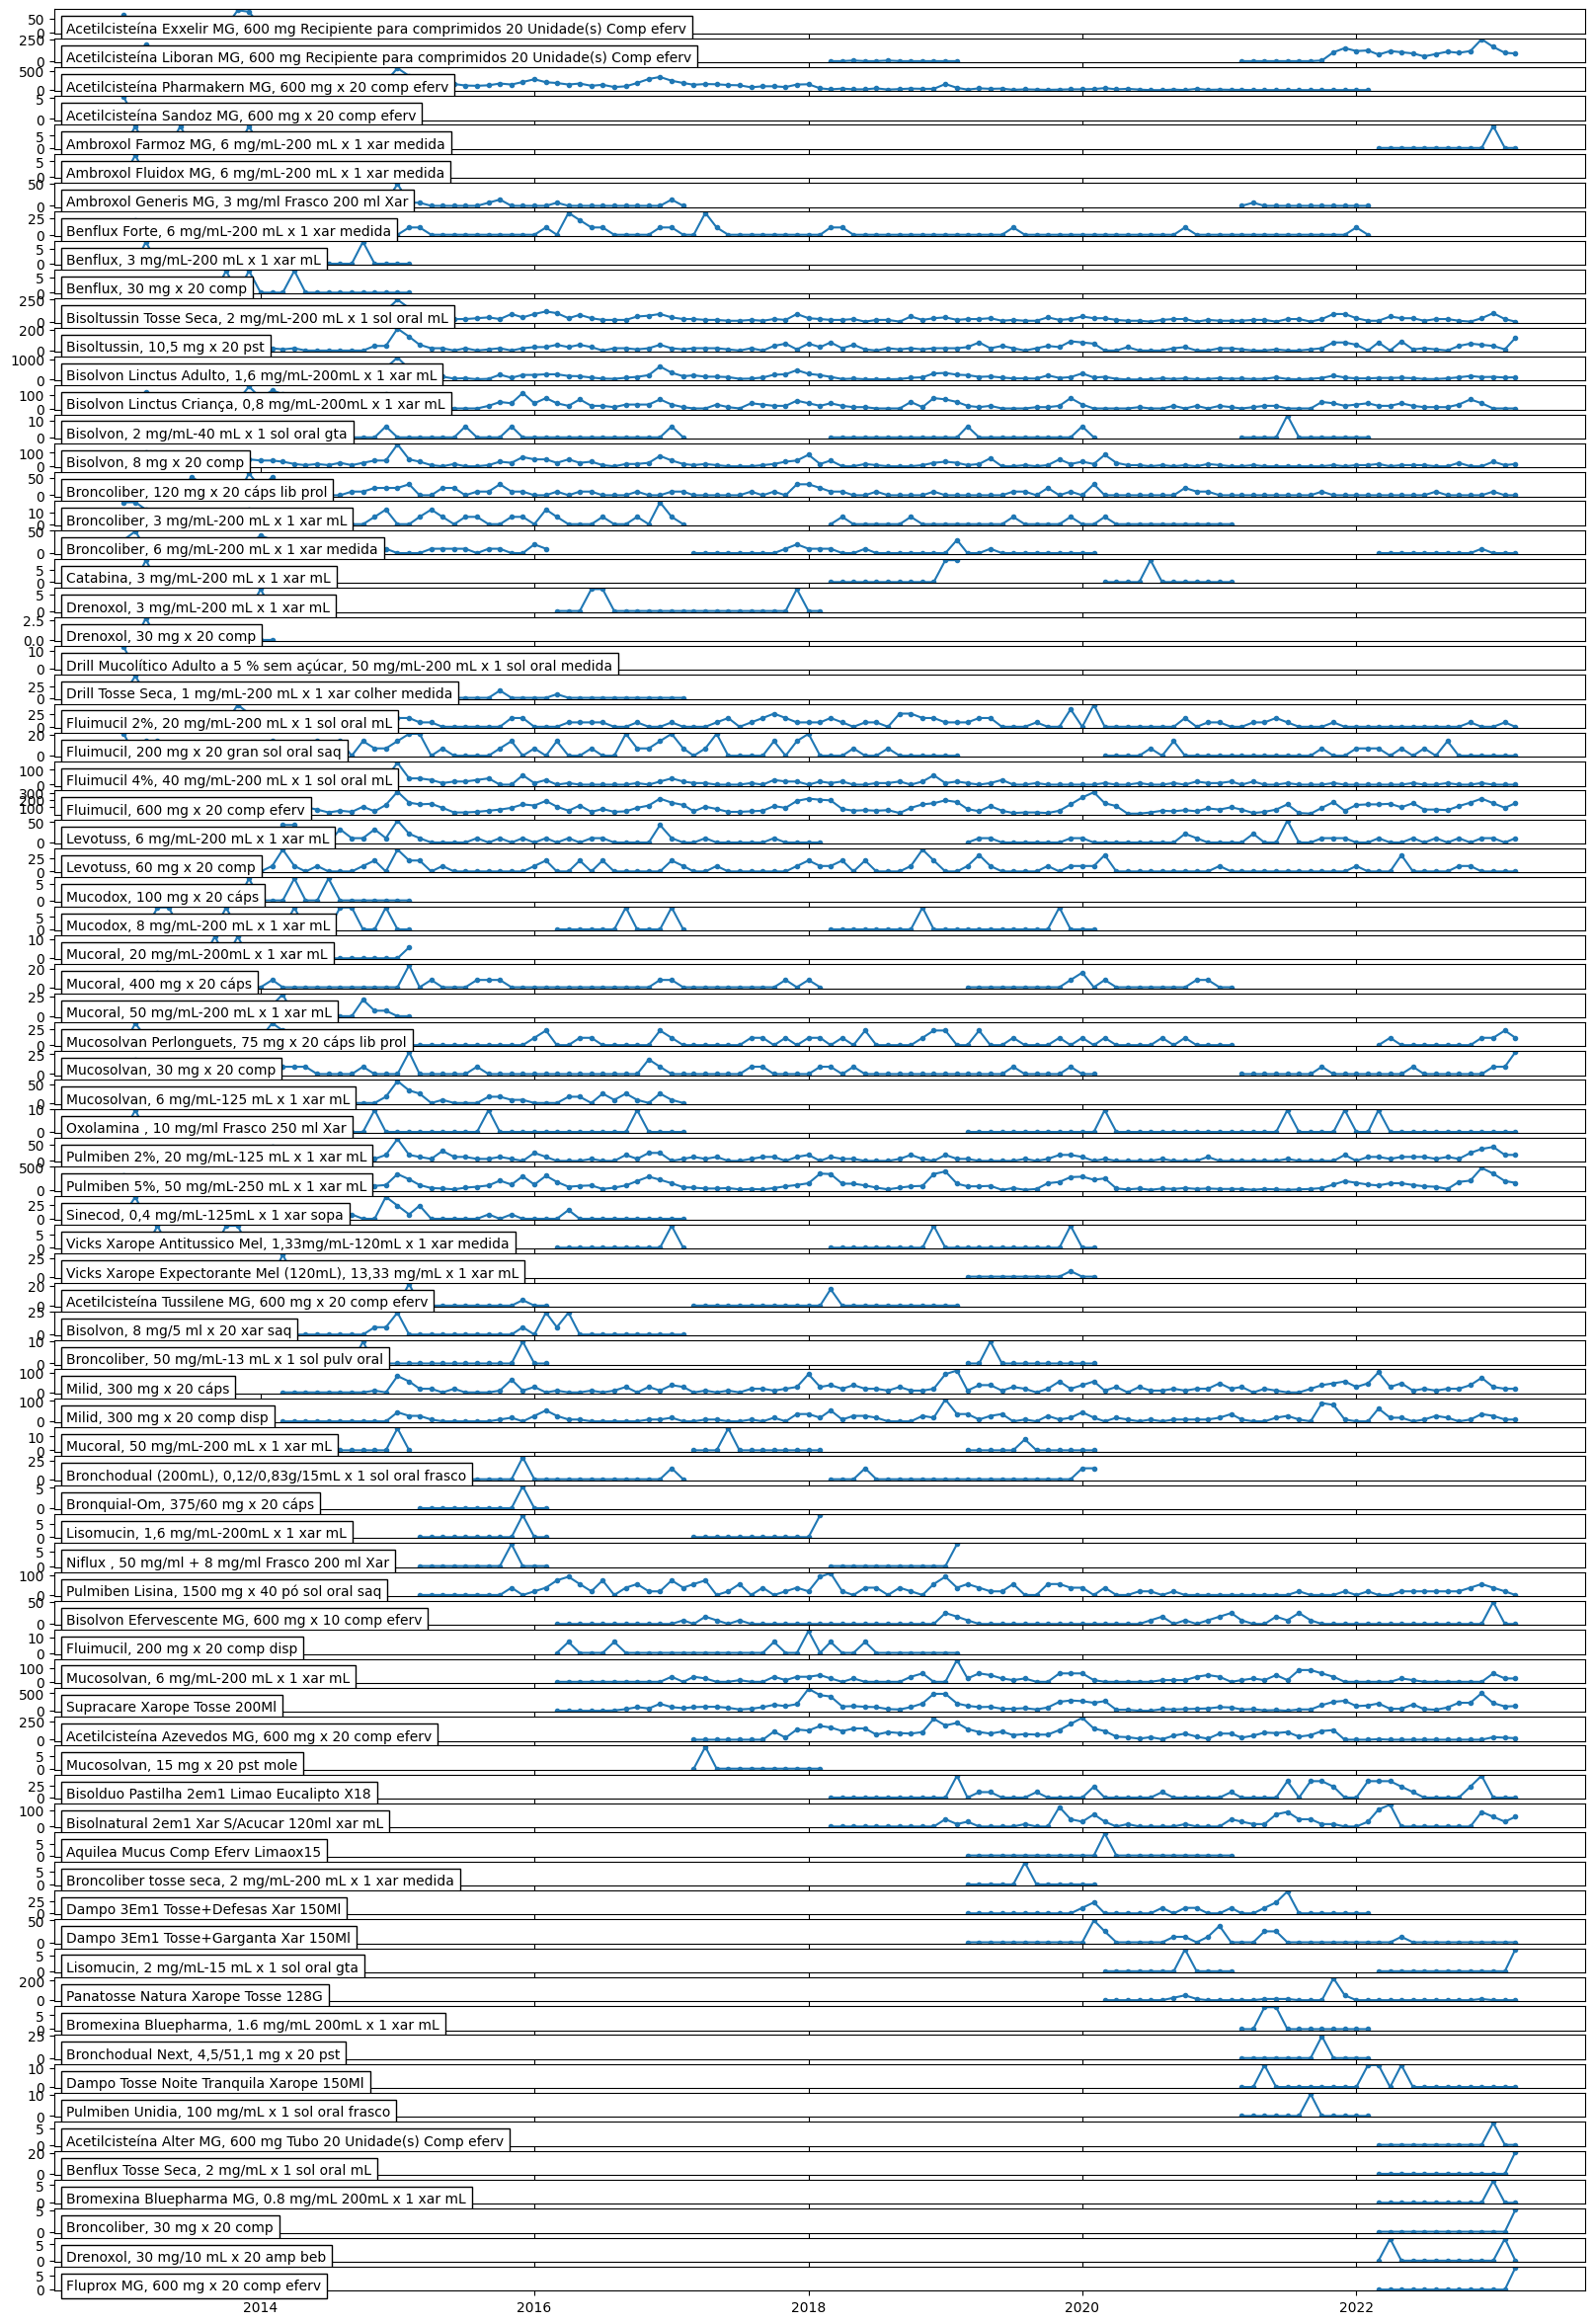

In [13]:
fig, ax = plt.subplots(79, 1, figsize=(20,30), sharex=True)
for i, col in enumerate(df.columns):
    ax[i].plot(df.loc[:,col], marker='.')
    med_name = df_metainfo.query('cod == @col').iloc[0,1]
    at = AnchoredText(med_name, loc="upper left")
    ax[i].add_artist(at)
plt.show()

In [14]:
with pd.option_context('display.max_rows', 10, 'display.min_rows', 25):
    display(df.describe().T.round(2))
    #display(df.mask(df == 0).describe().T.round(2))

,count,mean,std,min,25%,50%,75%,max
cod,,,,,,,,
5022561,26.0,18.79,23.96,0.0,0.0,13.72,21.96,82.35
5104377,63.0,44.47,55.93,0.0,0.0,20.55,78.77,253.45
5245972,110.0,97.15,96.37,0.0,19.5,78.00,149.50,565.50
5899281,14.0,0.37,1.40,0.0,0.0,0.00,0.00,5.24
4466397,27.0,1.33,3.25,0.0,0.0,0.00,0.00,8.98
...,...,...,...,...,...,...,...,...
5702907,13.0,1.64,5.92,0.0,0.0,0.00,0.00,21.36
5490800,13.0,0.48,1.73,0.0,0.0,0.00,0.00,6.22
9545418,13.0,0.39,1.41,0.0,0.0,0.00,0.00,5.09


In [15]:
df.to_csv('df_dados_tosse.csv')
df_metainfo.to_csv('df_metainfo_tosse.csv')

In [16]:
del at, ax, col, fig, i, med_name, numero_medicamentos

# 3. Agrupamento das séries por categorias de medicamentos

## 3.1. Tratamento dos dados

In [17]:
df_categ = pd.read_csv('categorias_medicamentos_tosse.csv', sep=';', encoding='cp1252')
df_categ.classif.value_counts()

classif
5.2.2 - Expetorantes    61
5.2.1 - Antitússicos    18
Name: count, dtype: int64

In [18]:
df_grouped = pd.merge(df_merged, df_categ.filter(['cod', 'classif']), on=['cod'], how='left')
df_grouped = df_grouped.drop(columns=['cod','nome','pvp']).groupby('classif').sum().T
df_grouped.index = pd.to_datetime(df_grouped.index)
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 123 entries, 2013-01-01 to 2023-03-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   5.2.1 - Antitússicos  123 non-null    float64
 1   5.2.2 - Expetorantes  123 non-null    float64
dtypes: float64(2)
memory usage: 2.9 KB


In [19]:
df_grouped.head()

classif,5.2.1 - Antitússicos,5.2.2 - Expetorantes
2013-01-01,66.33,1282.68
2013-02-01,172.54,1394.96
2013-03-01,115.52,1358.92
2013-04-01,95.56,598.05
2013-05-01,52.95,703.08


## 3.2. Visualização das séries temporais

In [20]:
fig = px.line(df_grouped, x=df_grouped.index, y=df_grouped.columns)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

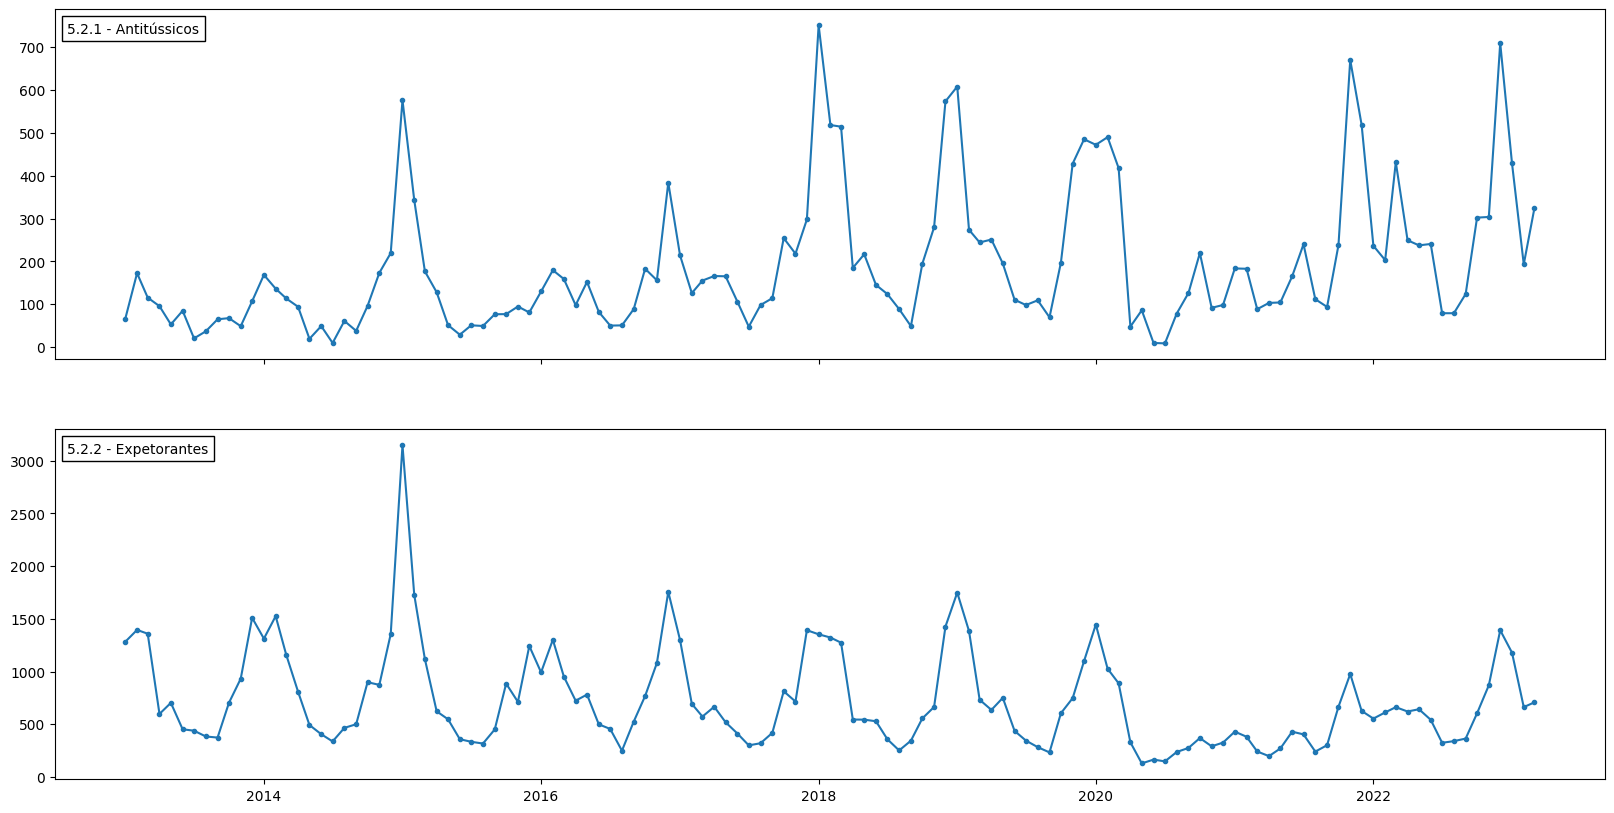

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
for i, col in enumerate(df_grouped.columns):
    ax[i].plot(df_grouped.loc[:,col], marker='.')
    med_name = col
    at = AnchoredText(med_name, loc="upper left")
    ax[i].add_artist(at)
plt.show()

# 4. Decomposição


## 4.1. Decomposição Aditiva

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decomposition_additive(df_grouped,col):
    decompose_additive = seasonal_decompose(df_grouped[col],model='additive')
    decompose_additive.plot()
    
    


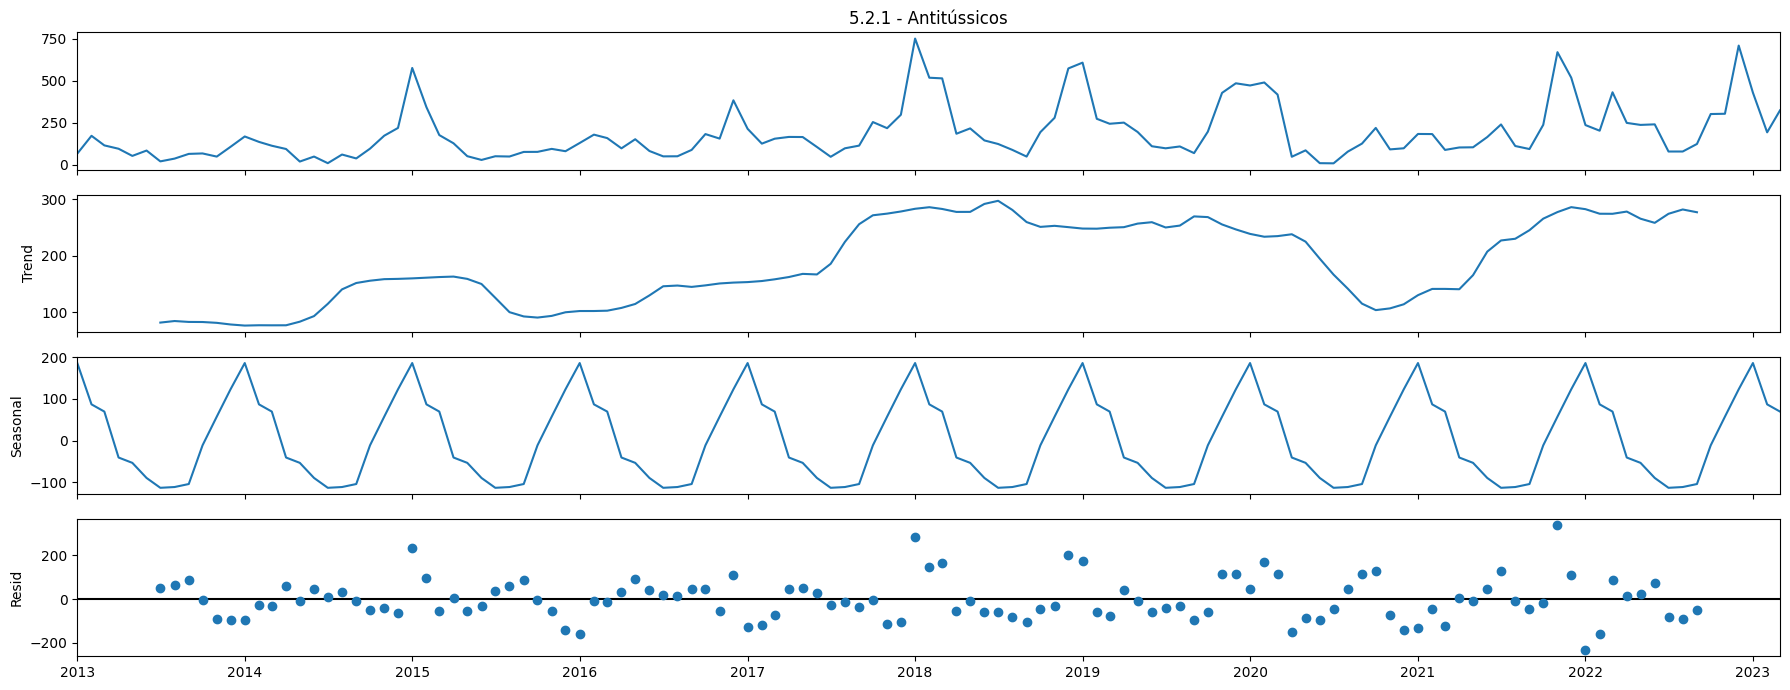

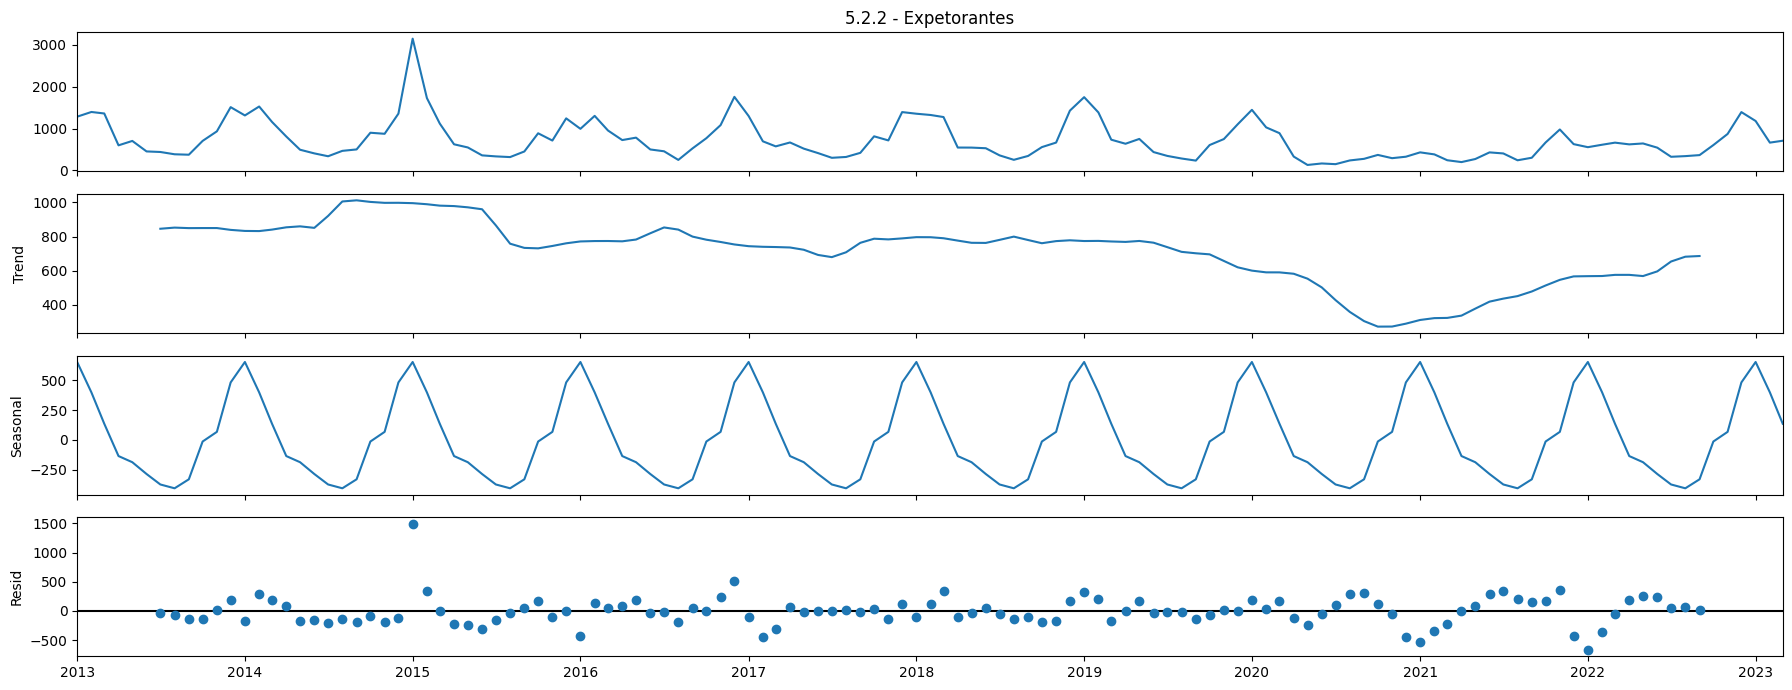

In [23]:
for col in df_grouped:
    decomposition_additive(df_grouped,col)

In [24]:
def decomposition_additive(df_grouped, col):
    decompose_additive = seasonal_decompose(df_grouped[col], model='additive')
    
    # Accessing the decomposed values
    df_decomp_additive = pd.DataFrame({
        'observed': decompose_additive.observed,
        'trend': decompose_additive.trend,
        'seasonal': decompose_additive.seasonal,
        'residual': decompose_additive.resid
    })
    
    return df_decomp_additive

for col in df_grouped:
    result = decomposition_additive(df_grouped, col)
        
    print(f"Decomposição aditiva para série '{col}':")
    print(result.head(15))
    print("\n" + "="*40 + "\n")


Decomposição aditiva para série '5.2.1 - Antitússicos':
            observed      trend    seasonal   residual
2013-01-01     66.33        NaN  186.063272        NaN
2013-02-01    172.54        NaN   86.956975        NaN
2013-03-01    115.52        NaN   69.650216        NaN
2013-04-01     95.56        NaN  -40.524923        NaN
2013-05-01     52.95        NaN  -53.310525        NaN
2013-06-01     84.80        NaN  -89.537052        NaN
2013-07-01     20.35  82.031250 -113.145085  51.463835
2013-08-01     36.84  84.787083 -111.290960  63.343877
2013-09-01     64.91  83.194583 -104.076918  85.792335
2013-10-01     67.62  83.047500  -11.334275  -4.093225
2013-11-01     48.82  81.584583   57.497809 -90.262392
2013-12-01    106.99  78.692500  123.051466 -94.753966
2014-01-01    168.62  76.756667  186.063272 -94.199938
2014-02-01    136.39  77.319583   86.956975 -27.886559
2014-03-01    113.45  77.202500   69.650216 -33.402716


Decomposição aditiva para série '5.2.2 - Expetorantes':
      

## 4.2. Decomposição STL


In [25]:
from statsmodels.tsa.seasonal import STL
def decomposition_STL(df_grouped,col):
    decompose_STL = STL(df_grouped[col]).fit()
    decompose_STL.plot()

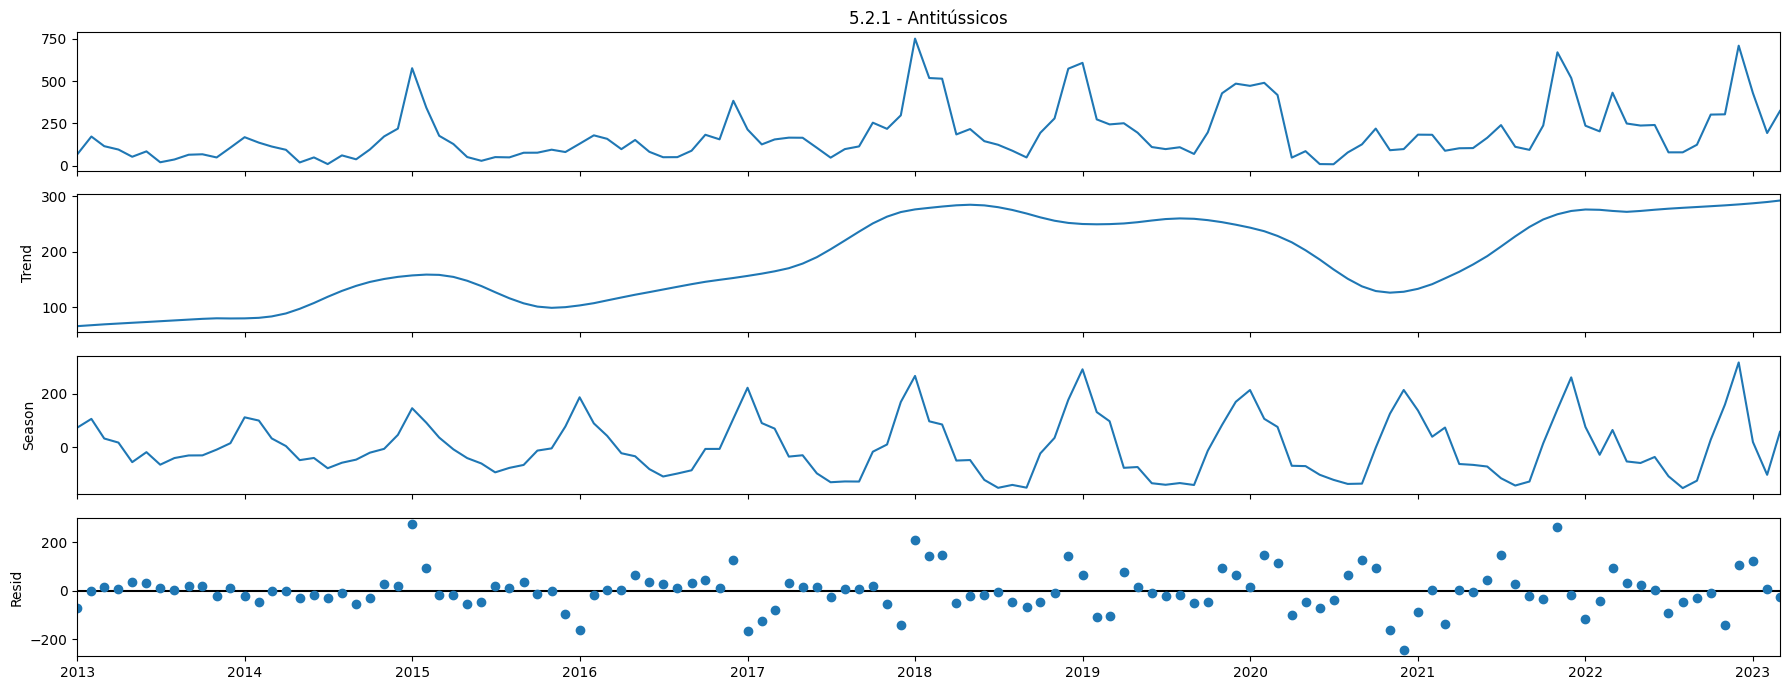

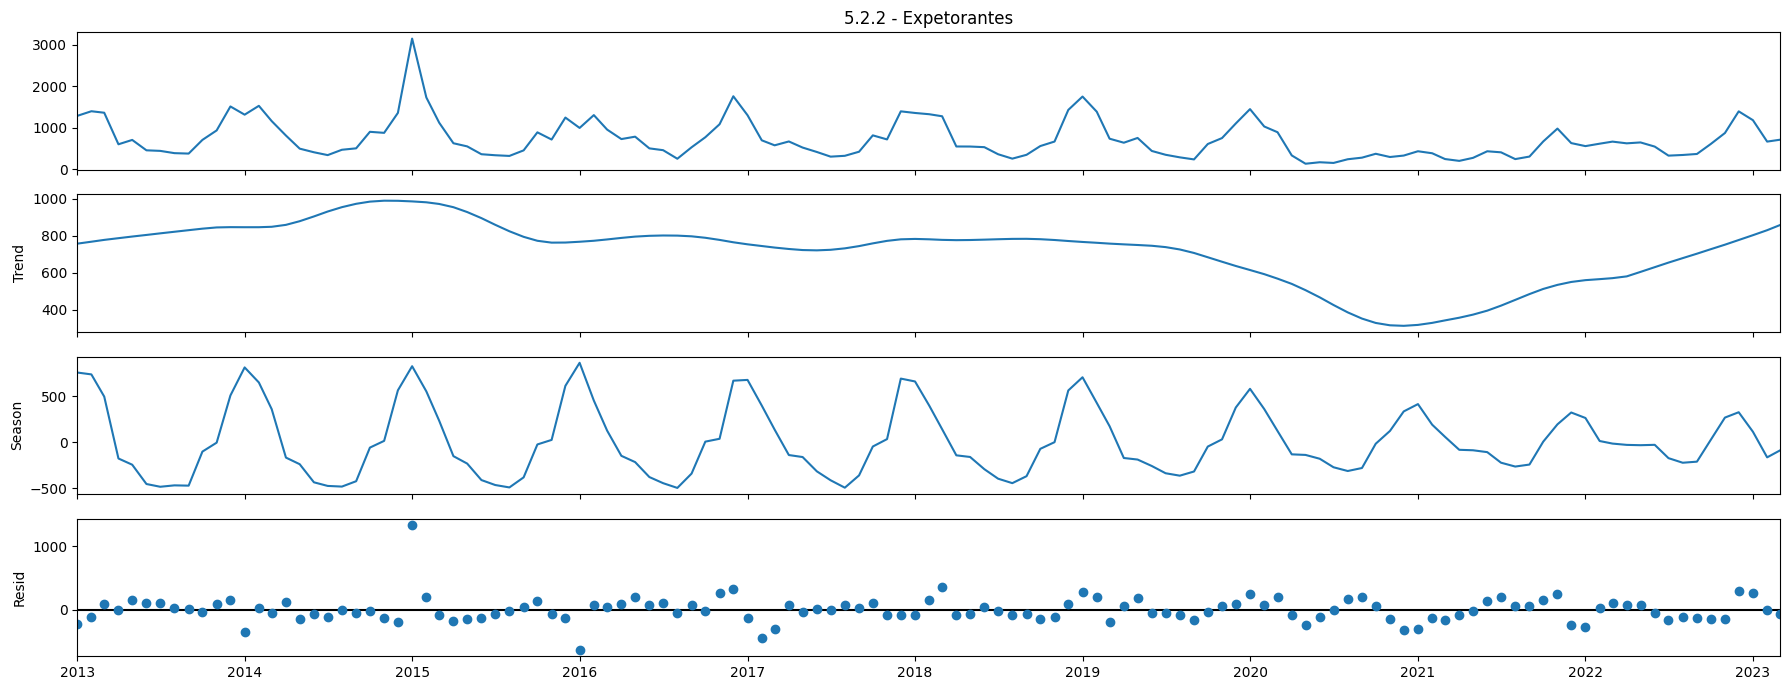

In [26]:
for col in df_grouped:
    decomposition_STL(df_grouped,col)

In [27]:
def decomposition_STL(df_grouped, col):
    decompose_STL = STL(df_grouped[col]).fit()
    
    df_decomp_STL = pd.DataFrame({
        'observed': decompose_STL .observed,
        'trend': decompose_STL .trend,
        'seasonal': decompose_STL .seasonal,
        'residual': decompose_STL .resid
    })
    
    return df_decomp_STL

for col in df_grouped:
    result = decomposition_STL(df_grouped, col)
        
    print(f"Decomposição STL para série '{col}':")
    print(result.head(5))
    print("\n" + "="*40 + "\n")

Decomposição STL para série '5.2.1 - Antitússicos':
            observed      trend    seasonal   residual
2013-01-01     66.33  65.901502   73.494948 -73.066450
2013-02-01    172.54  67.618248  106.458413  -1.536661
2013-03-01    115.52  69.172904   33.043334  13.303762
2013-04-01     95.56  70.617261   17.735411   7.207328
2013-05-01     52.95  72.004274  -55.449169  36.394895


Decomposição STL para série '5.2.2 - Expetorantes':
            observed       trend    seasonal    residual
2013-01-01   1282.68  757.554148  755.414158 -230.288307
2013-02-01   1394.96  768.192442  734.968275 -108.200717
2013-03-01   1358.92  778.046357  494.452521   86.421122
2013-04-01    598.05  787.303849 -176.581967  -12.671882
2013-05-01    703.08  796.159323 -243.854688  150.775365




## 4.3 Caracteristicas do STL

### 4.3.1 Força da tendência e da sazonalidade

In [28]:
def decomposition_STL(df_grouped, col):
    decompose_STL = STL(df_grouped[col]).fit()
    
    df_decomp_STL = pd.DataFrame({
        'observed': decompose_STL.observed,
        'trend': decompose_STL.trend,
        'seasonal': decompose_STL.seasonal,
        'residual': decompose_STL.resid
    })
    
    # Cálculo da força da tendência
    trend_var = np.var(df_decomp_STL['trend'] + df_decomp_STL['residual'])
    residual_var = np.var(df_decomp_STL['residual'])
    trend_strength = max(0, 1 - (residual_var / trend_var))
    
    # Cálculo da força da sazonalidade
    seasonal_var = np.var(df_decomp_STL['seasonal'] + df_decomp_STL['residual'])
    seasonal_strength = max(0, 1 - (residual_var / seasonal_var))
    
    return df_decomp_STL, trend_strength, seasonal_strength

for col in df_grouped:
    result, trend_strength, seasonal_strength = decomposition_STL(df_grouped, col)
        
    print(f"Decomposição STL para série '{col}':")
    print(result.head(5))
    print(f"Força da tendência para série '{col}': {trend_strength}")
    print(f"Força da sazonalidade para série '{col}': {seasonal_strength}")
    print("\n" + "="*40 + "\n")

Decomposição STL para série '5.2.1 - Antitússicos':
            observed      trend    seasonal   residual
2013-01-01     66.33  65.901502   73.494948 -73.066450
2013-02-01    172.54  67.618248  106.458413  -1.536661
2013-03-01    115.52  69.172904   33.043334  13.303762
2013-04-01     95.56  70.617261   17.735411   7.207328
2013-05-01     52.95  72.004274  -55.449169  36.394895
Força da tendência para série '5.2.1 - Antitússicos': 0.5085626394136128
Força da sazonalidade para série '5.2.1 - Antitússicos': 0.6556061652605608


Decomposição STL para série '5.2.2 - Expetorantes':
            observed       trend    seasonal    residual
2013-01-01   1282.68  757.554148  755.414158 -230.288307
2013-02-01   1394.96  768.192442  734.968275 -108.200717
2013-03-01   1358.92  778.046357  494.452521   86.421122
2013-04-01    598.05  787.303849 -176.581967  -12.671882
2013-05-01    703.08  796.159323 -243.854688  150.775365
Força da tendência para série '5.2.2 - Expetorantes': 0.45878461073926047

In [29]:
def decomposition_STL(df_grouped, col):
    decompose_STL = STL(df_grouped[col]).fit()
    
    df_decomp_STL = pd.DataFrame({
        'observed': decompose_STL .observed,
        'trend': decompose_STL .trend,
        'seasonal': decompose_STL .seasonal,
        'residual': decompose_STL .resid
    })
    
    return df_decomp_STL

## 4.4 Outliers

In [30]:
def outlier_tukey(df, column):
    """
    Given the data frame and a numeric column, outputs the outlier data frame.
    inputs: df - pandas data frame; column - string
    output: pandas data frame
    """
    Q1 = df.quantile(0.25).loc[column]
    Q3 = df.quantile(0.75).loc[column]
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    df_outliers = df.query(f'{column} < @lower_fence or {column} > @upper_fence')
    return df_outliers

In [31]:
for col in df_grouped:
    df_decomp_STL = decomposition_STL(df_grouped, col)
    
    # Detetar os outliers da coluna dos resíduos
    outliers = outlier_tukey(df_decomp_STL, 'residual')
    
    # Visualizar os outliers 
    cm = sns.color_palette("vlag", as_cmap=True)
    print(f"Outliers para a série '{col}':")
    display(outliers.filter(['residual']).style.background_gradient(cmap=cm))
    print("\n" + "="*40 + "\n")

Outliers para a série '5.2.1 - Antitússicos':


,residual
2015-01-01 00:00:00,272.863243
2016-01-01 00:00:00,-160.769990
2017-01-01 00:00:00,-165.394221
2018-01-01 00:00:00,208.041989
2018-02-01 00:00:00,142.063973
2018-03-01 00:00:00,147.713333
2018-12-01 00:00:00,143.981162
2020-02-01 00:00:00,146.487755
2020-11-01 00:00:00,-160.446630
2020-12-01 00:00:00,-244.236824




Outliers para a série '5.2.2 - Expetorantes':


,residual
2015-01-01 00:00:00,1337.023678
2016-01-01 00:00:00,-636.435933
2017-02-01 00:00:00,-448.266573


## 4.5 Estacionariedade

### 4.5.1 Teste KPSS (Teste Kwiatkowski–Phillips–Schmidt–Shin)

In [32]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

for col in df_grouped:
    print(f"KPSS Teste para a série '{col}':")
    kpss_test(df_grouped[col])
    print("\n" + "="*40 + "\n")

KPSS Teste para a série '5.2.1 - Antitússicos':
Results of KPSS Test:
Test Statistic           0.634970
p-value                  0.019457
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


KPSS Teste para a série '5.2.2 - Expetorantes':
Results of KPSS Test:
Test Statistic           0.457322
p-value                  0.052447
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64




### 4.5.2 Teste ADF (Teste Dickey-Fuller Aumentado)

In [33]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

for col in df_grouped:
    print(f"Teste ADF para a série '{col}':")
    adf_test(df_grouped[col])
    print("\n" + "="*40 + "\n")


Teste ADF para a série '5.2.1 - Antitússicos':
Results of Dickey-Fuller Test:
Test Statistic                  -1.740326
p-value                          0.410464
#Lags Used                      13.000000
Number of Observations Used    109.000000
Critical Value (1%)             -3.491818
Critical Value (5%)             -2.888444
Critical Value (10%)            -2.581120
dtype: float64


Teste ADF para a série '5.2.2 - Expetorantes':
Results of Dickey-Fuller Test:
Test Statistic                  -1.515382
p-value                          0.525889
#Lags Used                      13.000000
Number of Observations Used    109.000000
Critical Value (1%)             -3.491818
Critical Value (5%)             -2.888444
Critical Value (10%)            -2.581120
dtype: float64




### 4.5.3 Normalidade

In [34]:
import scipy.stats as stats

def jarque_bera_test(timeseries):
    name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
    
    # Calcula a estatística de Jarque-Bera e p-value
    jb_stat, jb_pvalue = stats.jarque_bera(timeseries)
    
    # Calcula a assimetria e curtose
    skewness = stats.skew(timeseries)
    kurtosis = stats.kurtosis(timeseries)
    
    # Retorna os resultados
    return dict(zip(name, [jb_stat, jb_pvalue, skewness, kurtosis]))

for col in df_grouped:
    print(f"Teste Jarque-Bera test para a série '{col}':")
    result = jarque_bera_test(df_grouped[col])
    
    # Imprime os resultados em linhas separadas
    print(f"Jarque-Bera: {result['Jarque-Bera']}")
    print(f"Chi^2 two-tail prob.: {result['Chi^2 two-tail prob.']}")
    print(f"Skew: {result['Skew']}")
    print(f"Kurtosis: {result['Kurtosis']}")
    
    print("\n" + "="*40 + "\n")


Teste Jarque-Bera test para a série '5.2.1 - Antitússicos':
Jarque-Bera: 70.55250143080384
Chi^2 two-tail prob.: 4.783204754112134e-16
Skew: 1.5647230811810515
Kurtosis: 1.9932156078741148


Teste Jarque-Bera test para a série '5.2.2 - Expetorantes':
Jarque-Bera: 184.58586140247095
Chi^2 two-tail prob.: 8.273503934634527e-41
Skew: 1.6762183216967776
Kurtosis: 4.97774266072652




# 5. Exportar dados para o notebook seguinte

In [35]:
df_grouped = df_grouped.reset_index()
df_grouped.to_csv('Dados_intermedios/df_nb1.csv', index=False)